<a href="https://www.kaggle.com/code/sajadahmadi/microscopic-fungi-image-classification?scriptVersionId=155402981" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Dataset Overview

This dataset comes with 5000 quality images for training. The images are from superficial fungal infections caused by yeasts, moulds, or dermatophyte fungi. The images have been manually labelled into five classes and curated with a subject matter expert assistance. The images have been cropped with automated algorithms to produce the final dataset.

You can find the reference article of the dataset at [P456 Defungi: direct mycological examination of microscopic fungi images](https://doi.org/10.1093/mmy/myac072.P456). There are 5 subfolders, representing the following fungi types:
* H1: Candida albicans
* H2: Aspergillus niger
* H3: Trichophyton rubrum
* H5: Trichophyton mentagrophytes
* H6: Epidermophyton floccosum

The data is sotred in 3 different sub directories with this format: **/kaggle/input/microscopic-fungi-images/{{partition name: train/test/valid}}/{{label name:H1/H2/H3/H5/H6}}/{{image_name.jpg}}**. Each folder contains the images related to one class of Fungi. I create a pathlib object from it to count the number of sub directories(which is equal to the number of classes/labels) in the training set and the number of training examples per class:

## importing libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import decomposition

import tensorflow as tf
import tensorflow.keras 
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import DenseNet121, VGG16
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score

import pathlib
from PIL import Image

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Exploring the data


Let's take a closer look at the dataset and think about these questions:

* How many examples do we have for training and testing?
* How big are the images?
* What's the percentage of each category we observe?

In [2]:
# path for each partition of the data
data_directory = pathlib.Path("/kaggle/input/microscopic-fungi-images/")

In [3]:
# creating a pathlib object for each partition
train_subdir = data_directory.joinpath("train")
validation_subdir = data_directory.joinpath("valid")
test_subdir = data_directory.joinpath("test")

In [4]:
training_images = [file for subdir in train_subdir.glob('*') for file in subdir.glob('*')]
validation_images = [file for subdir in validation_subdir.glob('*') for file in subdir.glob('*')]
test_images = [file for subdir in test_subdir.glob('*') for file in subdir.glob('*')]

print(f"Number of training examples: {len(training_images)}",
      f"\nNumber of validation examples: {len(validation_images)}",
f"\nNumber of test examples: {len(test_images)}")

Number of training examples: 5000 
Number of validation examples: 899 
Number of test examples: 902


**checking the balance of the training set**

We should check for the balance of the training set since it might affect model's performance drastically. Highly imbalanced datasets (as a rule of thumb, with classess whose size are less than 5% of the data) might tend to predict all observations to be from the majority class(and get a 95% or higher fake accuracy score).


In [5]:
# counting the number of observations per training labels
labels = []
image_count = []
for subdir in train_subdir.iterdir():
    count = 0
    label = subdir.name
    labels.append(label)
    for image in subdir.glob("*.jpg"):
        count += 1
    image_count.append(count)
print(f"there are {len(labels)} labels and {sum(image_count)} images in the data set\n")
print(labels,"-->", image_count)

there are 5 labels and 5000 images in the data set

['H3', 'H6', 'H5', 'H1', 'H2'] --> [1000, 1000, 1000, 1000, 1000]


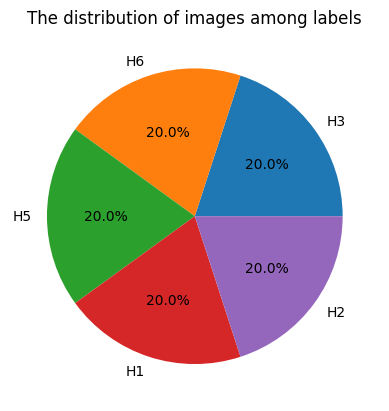

In [6]:
# using pie plot to show the distribution of training dataset images
plt.pie(image_count, labels = labels,autopct='%1.1f%%')
plt.title("The distribution of images among labels")
plt.show()

As we can see, the training dataset is completely balanced, making our training process much easier. There are one thousand images per label. 
As the last step, let's find the dimensions of an exemplar picture.

In [7]:
# creating a dictionary to store the metadata of all training set images
training_images_metadata = { "shapes" : [], "pixel_ranges" : []}
for image_path in training_images:
    img = Image.open(image_path)
    img_array = tf.keras.utils.img_to_array(img)
    shape = img_array.shape
    min_,max_ = img_array.min(), img_array.max()
    training_images_metadata["shapes"].append(shape)
    training_images_metadata["pixel_ranges"].append([min_,max_])

In [8]:
# finding the min and max value of pixel ranges and the unique shapes of the pictures
print("min. pixel values --> ",
      min(range_list[0] for range_list in training_images_metadata["pixel_ranges"]))
print("max. pixel value --> ",
max(range_list[1] for range_list in training_images_metadata["pixel_ranges"]))
print("shape of the images are --> ",set(training_images_metadata["shapes"]))

min. pixel values -->  0.0
max. pixel value -->  255.0
shape of the images are -->  {(179, 179, 3), (224, 224, 3)}


images are in range 0 to 255 with 3 different color channels and have two different shapes. 

# Creating train-dev-test sets

At this step, we create a batched tf.data.dataset object from each subdirectory of our data. we determine image sizes to be (224,224), with batches of 32. 

In [9]:
batch_size = 32
target_size = (224,224)

# creating the training, validation and test sets
train_set= image_dataset_from_directory(
    train_subdir,
    image_size=target_size,
    batch_size=batch_size,
)

validation_set= image_dataset_from_directory(
    validation_subdir,
    image_size=target_size,
    batch_size=batch_size,
)

test_set = image_dataset_from_directory(
    test_subdir,
    image_size=target_size,
    batch_size=batch_size,
)

Found 5000 files belonging to 5 classes.
Found 899 files belonging to 5 classes.
Found 902 files belonging to 5 classes.


In [10]:
# showing the shape of each batch of data
for image_batch, labels_batch in train_set:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


data are in the required shape by models, i.e,:
* 32: Batch size (number of images in each batch)
* 224: Height of each image
* 224: Width of each image
* 3: Number of color channels (RGB images)

Just to become more familiar with the datasets, let's examine the distribution of labels in the validation and test set also:

In [11]:
# creating a list of labels for each set of data
validation_labels = np.concatenate([label for pic, label in validation_set], axis=0)
test_labels = np.concatenate([label for pic, label in test_set], axis=0)

# creating a pandas series from the lists to find the proportion of labels 
validation_labels_dist = pd.Series(validation_labels).value_counts(normalize = True)*100
test_labels_dist = pd.Series(test_labels).value_counts(normalize = True)*100

print("the distribution of labels in the validation set is\n",validation_labels_dist)
print("\n")
print("the distribution of labels in the validation set is\n",test_labels_dist)

the distribution of labels in the validation set is
 0    48.609566
1    25.806452
2     9.010011
3     8.898776
4     7.675195
Name: proportion, dtype: float64


the distribution of labels in the validation set is
 0    48.447894
1    25.831486
2     9.090909
3     8.869180
4     7.760532
Name: proportion, dtype: float64


The distributioin of labels across the test and validation sets are not balanced and they have almost the same distributions. It won't make a problem for training our model since our model is going to be trained on a fully balanced dataset. 

## Visualizing the pictures

At this step, we visualize 9 exemplar pictures 

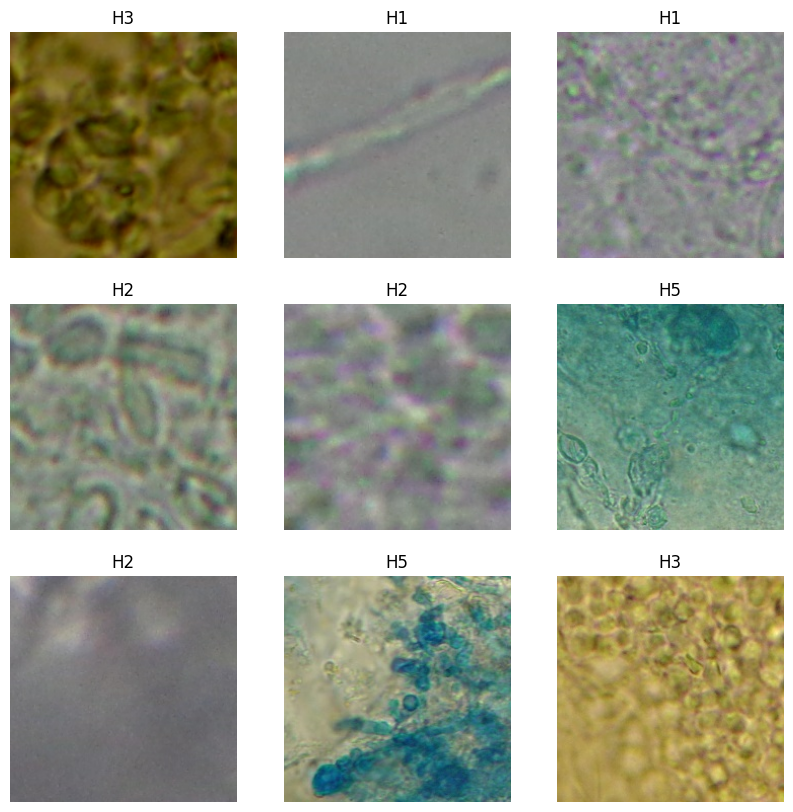

In [12]:
class_names = train_set.class_names # finding the class names of the dataset


plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1): # use take method to create an iterator and take 1 batch of data
  for i in range(9): # each batch has 32 images and labels, we only show 9 of them
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Since these are mictroscopic images of fungies, they're not easy to distinguish by users outside the domain knowledge. To my understanding, H5 class is like bubbles and is rounded, while H6 and H5 are more stretched and thiner. 

## Configuring the datasets for better performance

* It is recommended to cache the datasets, using cache() method before feeding the data to the model. It stores the elements of a dataset in memory or on disk and helps avoid redundant data loading during training.
 
* Also, prefetch() methods overlaps data loading and model execution and prefetches batches in the background while the model is training on the current batch and helps reduce data loading latency and keeps the GPU or CPU busy.

In [13]:
AUTOTUNE = tf.data.AUTOTUNE #dynamically tuning the parallelism based on available system resources

train_ds = train_set.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = validation_set.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_set.cache().prefetch(buffer_size=AUTOTUNE)

# Feature extraction using DenseNet

[DenseNet-121](https://doi.org/10.1080/0952813X.2021.1960638) is a convolutional neural network (CNN) architecture that belongs to the family of Densely Connected Convolutional Networks (DenseNets). The key characteristic of DenseNet architectures is the dense connectivity pattern, where each layer receives input from all preceding layers. This model attempts to  solve  the problem  of  vanishing gradients in deep CNN architecture by reusing features through a connection of each block with one another. Below the structure of this model is shown:


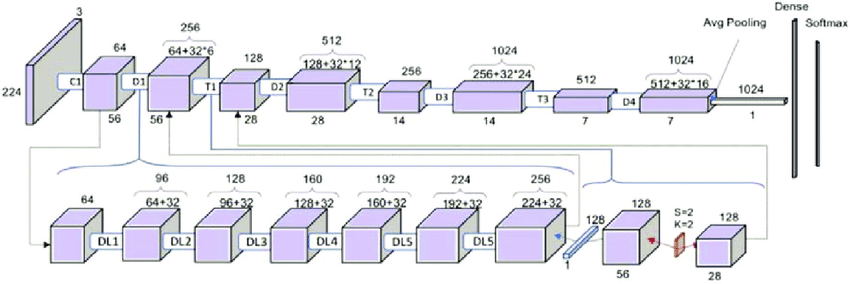
image by [Jee, Gaurav et al](https://doi.org/10.1080/0952813X.2021.1960638)

<div style="text-align: center"> The architecture  of DenseNet121 with Dense block  (D) Transition  blocks (T)  and Dense Layers </div>




In [14]:
# creating the base model
densenet_base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3))
densenet_base_model.trainable = False

29084464/29084464 [==============================] - 0s 0us/step


In [15]:
# getting the result of applying densenet model
extracted_features = densenet_base_model.predict(train_set)

157/157 [==============================] - 23s 85ms/step


### Using PCA to visualize the extracted features

the output (training_features) of the densenet will be a 4D array (batch size, height, width, channels):

In [16]:
# finding the shapes of the model output
n_training, x, y, z = extracted_features.shape
print("Number of training samples:", n_training)
print("Height of each feature map:", x)
print("Width of each feature map:", y)
print("Number of channels in each feature map:", z)

Number of training samples: 5000
Height of each feature map: 7
Width of each feature map: 7
Number of channels in each feature map: 1024


As you remember, we have 5000 training pictures. the output of the DenseNet121 model transform them from (224,224,3) shape into (7,7,1024)(a reduction in the height and width of pictures and increase in the number of chaneels)

In [17]:
#reduce the dimensionality to 2 principal components.
pca_2 = decomposition.PCA(n_components = 2)

#  reshapeing the train_features array into a 2D array
X = extracted_features.reshape((n_training, -1))
pca_2.fit(X)


transformed_data = pca_2.transform(X) 
print("the shape of the transformed data: ", transformed_data.shape)
print("the percentage of variance explained by each of the selected components ",
      np.round(pca_2.explained_variance_ratio_,3)*100)

the shape of the transformed data:  (5000, 2)
the percentage of variance explained by each of the selected components  [28.2      15.700001]


We have 5000 rows(training observations), now each one of these training examples(that belongs to a specific class) has only two dimensions(previously, they had 7*7*1024 dimensions). now, we can visualize them using a scatter plot:

/tmp/ipykernel_26/144537948.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 2, i + 1)


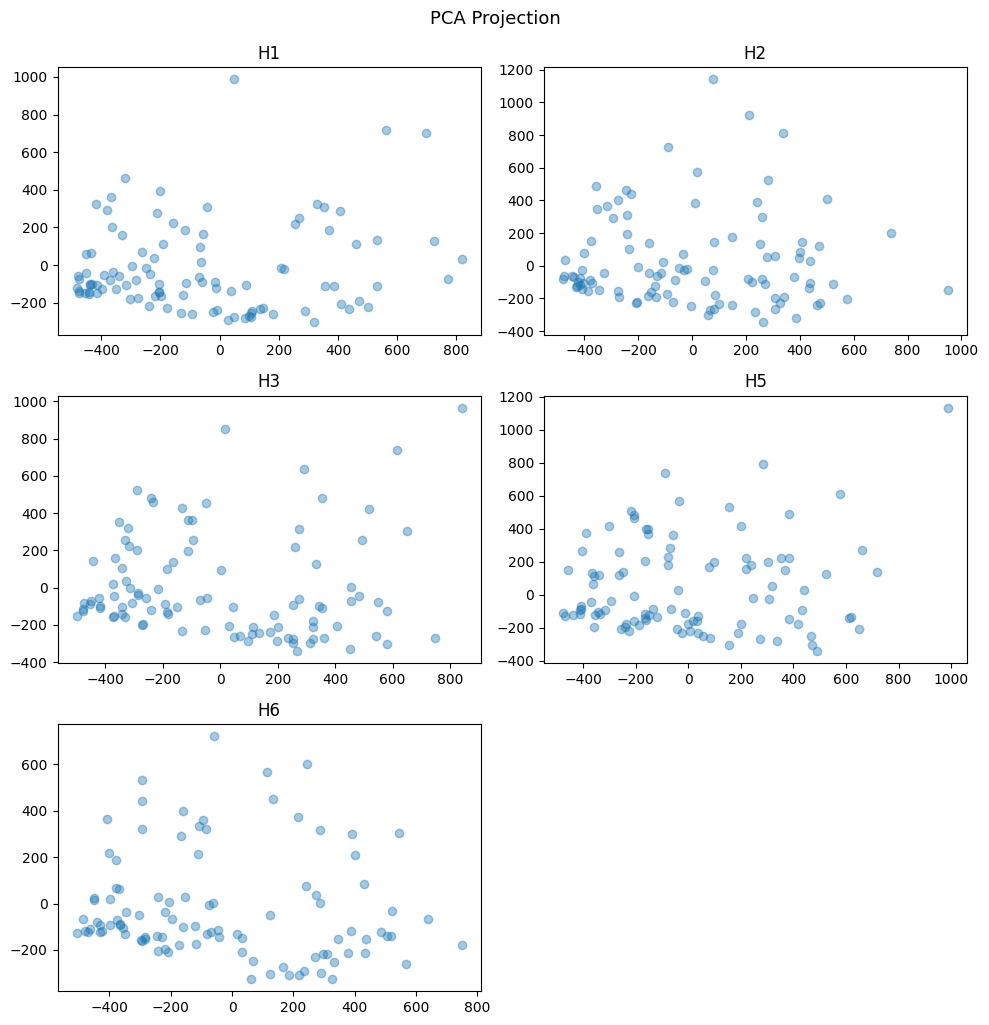

In [18]:
first_component = transformed_data[:,0]
second_component = transformed_data[:,1]
training_labels = np.concatenate([label for pic, label in train_set], axis=0)

# creating a separeted scatter plot for each class
plt.subplots(figsize=(10,10))
for i, class_name in enumerate(class_names):
    plt.subplot(3, 2, i + 1)
    plt.scatter(first_component[training_labels == i][:100], # showing 100 examples of each class
                second_component[training_labels == i][:100],
                label = class_name, alpha=0.4)
    plt.title(class_name)

plt.tight_layout()
plt.suptitle("PCA Projection", y = 1.02, fontsize = 13)
plt.show()


By comparing the outcome of the densent model after applying PCA, we tend to find whether we can find some similiarities (using a simple 2D scatter plot) by human-eye inspection or not. 
H2, H3,H5 and H6 have shown similar behaviors, while  H1 is the most distinctive class for this model. 

## Data Augmentation

In data augmentation,we create synthetic data from the real data to improve the generalization and robustness of our model. In fact, we feed our model with different versions of the same file, so it won't get sensitive to a specific direction, size, gesture, or ...(any pattern that is not related to the class of data). In fact, we are vaccinating our model for different versions of the same virus!

I apply random rotation, zoom, flipp, shifting image up and down, change in contrast and brightness .

In [19]:
data_augmentation =  tf.keras.Sequential([
    layers.RandomRotation(factor=0.2),  # Random rotation (up to 20%)
    layers.RandomZoom(height_factor=0.2, width_factor=0.2),  # Random zoom
    layers.RandomFlip(mode="horizontal"),  # Random horizontal flip
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),  # Random translation
    layers.RandomContrast(factor=0.2),  # Random contrast adjustment
    layers.RandomBrightness(factor=0.2),  # Random brightness adjustment
])

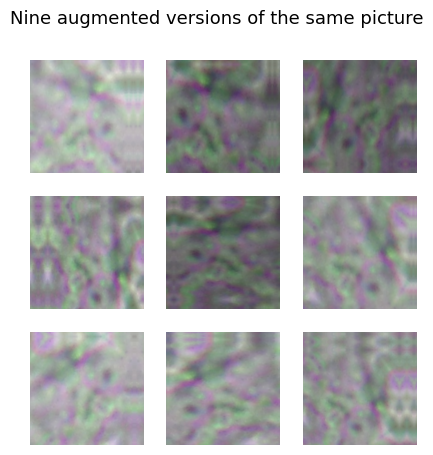

In [20]:
plt.figure(figsize = (5,5))
for image, _ in train_set.take(1):
    first_image = image[2] # selecting the second image as an example
    for i in range(9): #apply the augmentation layer 9 times      
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0)) 
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')
    
plt.suptitle('Nine augmented versions of the same picture', fontsize=13)
plt.show()

## Transfer learning using DenseNet

At this step, we add a "top" to the previous model to flatten the outcome (extracted features) and find their predicted classes using a fully connected network. I create the whole model using keras functional API. Two new layers are used in this model:
1. Droput: during training, random neurons are "dropped out"(switched off) with a certain probability (dropout rate). This helps to prevent the neurons at next layers rely too much on the previous neurons and improves model's generalization. 
2. Global Average Pooling: global average pooling computes the average value of each feature  across the entire spatial dimensions. It is usually used to replace the flatten + dense layer at the top of the model.

In [21]:
# creating layers
densenet_base_model = DenseNet121(weights='imagenet', include_top=False)
densenet_base_model.trainable = False
global_average_layer = layers.GlobalAveragePooling2D()


# building the model
inputs = tf.keras.Input(shape=(224, 224, 3))
augmented = data_augmentation(inputs)
features_extracted = densenet_base_model(augmented)
avg_pooling = global_average_layer(features_extracted)
dropout = tf.keras.layers.Dropout(0.5)(avg_pooling)
outputs = layers.Dense(5, activation='softmax')(dropout)
model_densenet = tf.keras.Model(inputs, outputs)

In the next step, I compile the model using "sparse_categorical_crossentropy" since I haven't one-hot encoded the y labels previously.

In [22]:
# compiling the model using Adam optimizer 
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model_densenet.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
EPOCHS = 20

Before fitting the data, I create two callbacks for the model.
1. early_stopping:  to avoid overfitting on the training data by monitoring the loss of validation data. 
2. lr_plateau:  to reduce the learning rate if the validation loss does not improve for 5 consecutive epochs. in this scenario, the learning rate will be adjuste by multipying 0.5. the min value for learning rate will be 1e-7.

In [23]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_plateau = ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.5, min_lr=1e-7)

In [24]:
history_densenet = model_densenet.fit(train_ds, validation_data = val_ds,
                                     epochs = EPOCHS,
                                     callbacks = [early_stopping,lr_plateau])

Epoch 1/20
157/157 [==============================] - 30s 136ms/step - loss: 7.7975 - accuracy: 0.2184 - val_loss: 1.9962 - val_accuracy: 0.2647 - lr: 1.0000e-04
Epoch 2/20
157/157 [==============================] - 17s 109ms/step - loss: 5.8382 - accuracy: 0.2618 - val_loss: 1.5661 - val_accuracy: 0.4305 - lr: 1.0000e-04
Epoch 3/20
157/157 [==============================] - 17s 110ms/step - loss: 5.2994 - accuracy: 0.2830 - val_loss: 1.5497 - val_accuracy: 0.4661 - lr: 1.0000e-04
Epoch 4/20
157/157 [==============================] - 17s 111ms/step - loss: 4.5244 - accuracy: 0.3212 - val_loss: 1.4724 - val_accuracy: 0.4661 - lr: 1.0000e-04
Epoch 5/20
157/157 [==============================] - 18s 112ms/step - loss: 4.0421 - accuracy: 0.3356 - val_loss: 1.4113 - val_accuracy: 0.4928 - lr: 1.0000e-04
Epoch 6/20
157/157 [==============================] - 18s 113ms/step - loss: 3.5536 - accuracy: 0.3534 - val_loss: 1.3498 - val_accuracy: 0.5072 - lr: 1.0000e-04
Epoch 7/20
157/157 [========

In [25]:
model_comparison = {}
model_comparison['densenet'] = pd.DataFrame(history_densenet.history)

### Plotting the training and validation curves
Here I create a function to show the performance of models to better understand what happens inside them while training.

In [26]:
def plot_performance(model_name, epochs = EPOCHS):
  dataframe = model_comparison[model_name]
  plt.figure(figsize = (12,3))

  plt.subplot(1,2,1)
  plt.plot(dataframe[["val_loss", "loss"]])
  plt.xticks(np.arange(0,epochs,5), np.arange(1, epochs+1,5))
  plt.title("Loss")
  plt.legend(["val_loss", "loss"])

  plt.subplot(1,2,2)
  plt.plot(dataframe[["val_accuracy", "accuracy"]])
  plt.legend(["val_accuracy", "accuracy"], loc = "lower right")
  plt.xticks(np.arange(0,epochs,5), np.arange(1, epochs+1,5))
  plt.title("Accuracy")

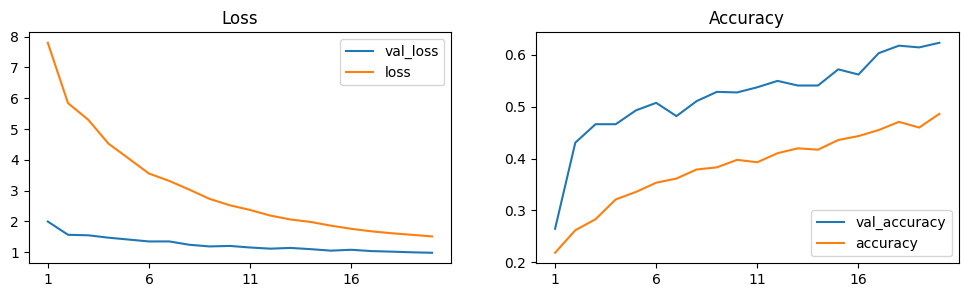

In [27]:
# showing model's performance
plot_performance('densenet')

## Transfer learning using VGG16

VGG16 consists of 13 convolutional layers and 3 fully connected layers(in total, 16, VGG16). The architecture is characterized by the repeated use of 3x3 convolutional filters, which helps maintain a small receptive field and allows for a deeper network. In the picture below you can see the structure of VGG16 model:

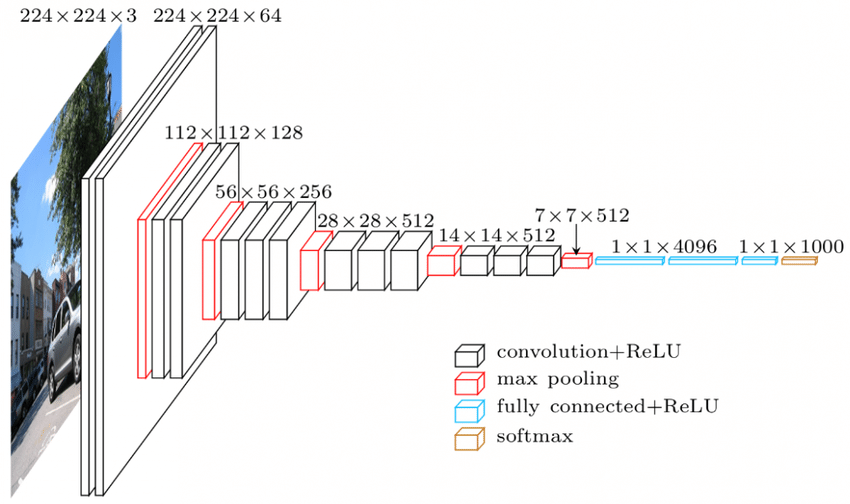
image by [Loukadakis, Manolis et al.](https://www.researchgate.net/publication/327070011_Accelerating_Deep_Neural_Networks_on_Low_Power_Heterogeneous_Architectures)

<div style="text-align: center"> VGG-16 neural network architecture </div>


In [28]:
# loading the base model
vgg16_base_model = VGG16(input_shape=(224,224,3), include_top=False, weights='imagenet')
vgg16_base_model.trainable = False # freezing base_model's layers
global_average_layer = layers.GlobalAveragePooling2D()

# 
inputs = tf.keras.Input(shape=(224, 224, 3))
augmented = data_augmentation(inputs)
features_extracted = vgg16_base_model(augmented)
avg_pooling = global_average_layer(features_extracted)
dropout = tf.keras.layers.Dropout(0.5)(avg_pooling)
outputs = layers.Dense(5, activation='softmax')(dropout)
model_vgg16 = tf.keras.Model(inputs, outputs)                                     
                                      
model_vgg16.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 2565 

In [29]:
# compiling the model just like before
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model_vgg16.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [30]:
history_vgg16 = model_vgg16.fit(
    train_set, epochs=EPOCHS, validation_data=validation_set,
    callbacks = [early_stopping,lr_plateau])

Epoch 1/20
157/157 [==============================] - 33s 172ms/step - loss: 4.5763 - accuracy: 0.2048 - val_loss: 2.3839 - val_accuracy: 0.2937 - lr: 1.0000e-04
Epoch 2/20
157/157 [==============================] - 25s 156ms/step - loss: 3.7497 - accuracy: 0.2332 - val_loss: 1.9313 - val_accuracy: 0.3593 - lr: 1.0000e-04
Epoch 3/20
157/157 [==============================] - 24s 155ms/step - loss: 3.2277 - accuracy: 0.2792 - val_loss: 1.5969 - val_accuracy: 0.4305 - lr: 1.0000e-04
Epoch 4/20
157/157 [==============================] - 25s 155ms/step - loss: 2.8560 - accuracy: 0.3086 - val_loss: 1.4047 - val_accuracy: 0.4805 - lr: 1.0000e-04
Epoch 5/20
157/157 [==============================] - 24s 155ms/step - loss: 2.5932 - accuracy: 0.3364 - val_loss: 1.2908 - val_accuracy: 0.5184 - lr: 1.0000e-04
Epoch 6/20
157/157 [==============================] - 24s 155ms/step - loss: 2.3110 - accuracy: 0.3694 - val_loss: 1.1900 - val_accuracy: 0.5662 - lr: 1.0000e-04
Epoch 7/20
157/157 [========

In [31]:
model_comparison["vgg16"] = pd.DataFrame(history_vgg16.history)

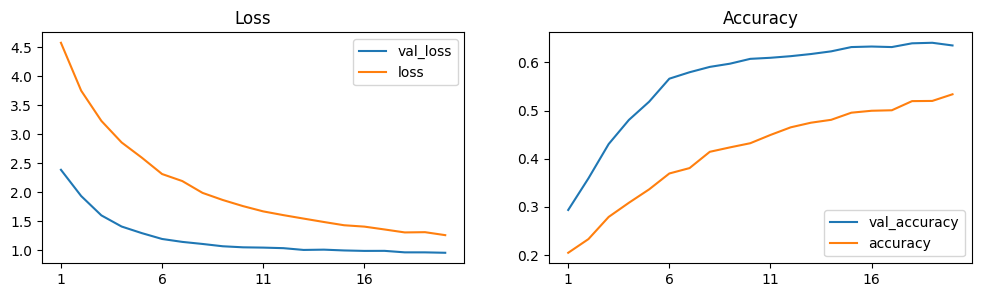

In [32]:
plot_performance("vgg16")

The loss and accuracy curve of the VGG16 model showed a smoother behavior. Let's check the accuracy score of both models on the test set to choose one of them:

In [33]:
vgg16_results = model_vgg16.evaluate(test_ds)
densenet_results = model_densenet.evaluate(test_ds)

29/29 [==============================] - 4s 138ms/step - loss: 0.9854 - accuracy: 0.6053


In [34]:
print("VGG16 model test loss and accuracy score(in order):", vgg16_results[0],vgg16_results[1] )
print("DenseNet model test loss and accuracy score(in order):", densenet_results[0],densenet_results[1])

VGG16 model test loss and accuracy score(in order): 0.9319728016853333 0.635254979133606
DenseNet model test loss and accuracy score(in order): 0.9854319095611572 0.6053215265274048


Although accuracy score is not a comprehensive measure for an imbalanced dataset with 5 classes, I use it as an early indicator to choose between the two models. As we expected, the VGG16 model that showed a smoother behavior got a higher accuracy score and lower loss in comparison to the DenseNet model. 

## Fine tuning the VGG16

Fine tuning, in most cases, is when we decide to unfreeze (some of the final and consecutive) layers of the base model(the model that we used for transfer learning) to make the model more specific to our task. As a result, we might get a higher performance score for our model. 

**Un-freeze the top layers of the model**

In [35]:
# how many layers are in the base model?
print("Number of layers in the base model: ", len(vgg16_base_model.layers))

vgg16_layers = [layer.name for layer in vgg16_base_model.layers]
print(vgg16_layers)

Number of layers in the base model:  19
['input_4', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool']


There are 19 layers in this model. The last 4 layers are a new start after a pooling layer('block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool'). I select this part of the model to be fine tuned:

In [36]:
# swithcing on all layers to be trainable
vgg16_base_model.trainable = True

# swithcing off(freezing) all layers except the last 4 layers
fine_tune_last = 4
for layer in vgg16_base_model.layers[:-fine_tune_last]:
    layer.trainable = False
    

Since we are training a larger model, it might overfit so fast to the training data. So it's recommended to use a lower learning rate. instead of 1e-4, I use 1e-5 as the new learning rate. other settings are the same as before for compiling the model:

In [37]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model_vgg16.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [38]:
model_vgg16.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                           

I run the model 10 epochs for fine tuning and continue learning(from the last epoch). 

In [39]:
fine_tune_epochs = 10
total_epochs =  EPOCHS + fine_tune_epochs

history_fine = model_vgg16.fit(train_set,
                         epochs=total_epochs,
                         initial_epoch=history_vgg16.epoch[-1],
                         validation_data=validation_set)

Epoch 20/30
157/157 [==============================] - 32s 178ms/step - loss: 1.0849 - accuracy: 0.5742 - val_loss: 0.8869 - val_accuracy: 0.6630
Epoch 21/30
157/157 [==============================] - 29s 176ms/step - loss: 0.9637 - accuracy: 0.6252 - val_loss: 0.7979 - val_accuracy: 0.6830
Epoch 22/30
157/157 [==============================] - 28s 175ms/step - loss: 0.8655 - accuracy: 0.6494 - val_loss: 0.7542 - val_accuracy: 0.6963
Epoch 23/30
157/157 [==============================] - 27s 174ms/step - loss: 0.8052 - accuracy: 0.6730 - val_loss: 0.7138 - val_accuracy: 0.7063
Epoch 24/30
157/157 [==============================] - 28s 175ms/step - loss: 0.7499 - accuracy: 0.7022 - val_loss: 0.6835 - val_accuracy: 0.6986
Epoch 25/30
157/157 [==============================] - 28s 175ms/step - loss: 0.7151 - accuracy: 0.7142 - val_loss: 0.6479 - val_accuracy: 0.7219
Epoch 26/30
157/157 [==============================] - 28s 175ms/step - loss: 0.7014 - accuracy: 0.7168 - val_loss: 0.6268 -

In [40]:
fine_tune_df = pd.DataFrame(history_fine.history)
model_comparison['vgg16_fineTuned'] = pd.concat([model_comparison['vgg16'],fine_tune_df]).reset_index()

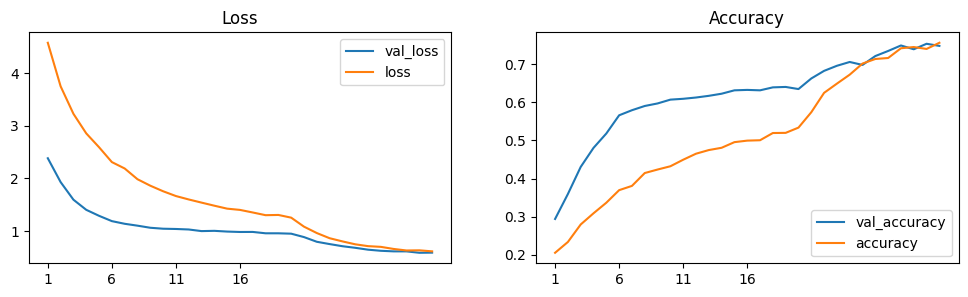

In [41]:
plot_performance('vgg16_fineTuned')

Fune tuning decreased training loss very fast, but with a lower rate for the training set. This proccess also improved validation accuracy from 64.4% to 76.4%.

It's time to find the final classification report on the test data.

# Measuring the final results

In [42]:
predictions = model_vgg16.predict(test_ds)
vgg16_fineTuned_results = model_vgg16.evaluate(test_ds)

29/29 [==============================] - 3s 119ms/step - loss: 0.5808 - accuracy: 0.7749


In [43]:
print("the VGG16 tuned model test loss and accuracy score(in order):", vgg16_fineTuned_results[0],vgg16_fineTuned_results[1] )

the VGG16 tuned model test loss and accuracy score(in order): 0.5807520151138306 0.774944543838501


Model was capable of generalizing results to the test set also. It got 76.8% accuracy score on the test set with a low loss value(0.57) in comparions to the first epochs of the model.

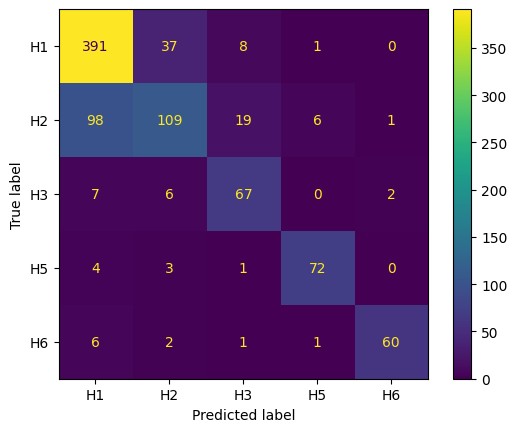

In [44]:
# true labels using test dataset
y_true = np.concatenate([label for pic, label in test_ds], axis=0)

# final predicted labels 
y_pred = np.argmax(predictions, axis=1)

# showing the confusion matrix of the second model
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                            display_labels=class_names)
disp.plot()
plt.show()

In [45]:
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

              precision    recall  f1-score   support

          H1      0.773     0.895     0.829       437
          H2      0.694     0.468     0.559       233
          H3      0.698     0.817     0.753        82
          H5      0.900     0.900     0.900        80
          H6      0.952     0.857     0.902        70

    accuracy                          0.775       902
   macro avg      0.803     0.787     0.789       902
weighted avg      0.771     0.775     0.764       902



## Results
* The model showed the highest precision score for the H6 class and the lowest for the H2 class.
* if we consider f1 score as a measure for the overal performance of the model, our model's performance is as follow: H6, H5, H1, H3, and H2. for H2, the model's performance was just a little bit higher than 0.5.
* The overall accuracy, as discussed, was 76.8% after 30 epochs. 

### Future actions
* We can run the tuned vgg16 model for a higher number of epochs like 50 or more
* also, we can add a more advanced top to the base model. The top layers i used were the simplest ones for the structure.
* We can test other base models like InceptionV3, MobileNet and ... and compare the results. 